In [20]:
import os
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import importlib.util
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# GCN関数
def gcn(x):
    mean = np.mean(x, axis=(1,2,3), keepdims=True)
    std = np.std(x, axis=(1,2,3), keepdims=True)
    return (x - mean) / (std + 1.E-6)

# 新しいZCA Whiteningクラス
class ZCA_Whitening:
    def __init__(self, epsilon=1E-6):
        self.epsilon = epsilon
        self.mean = None
        self.PCA_mat = None
        
    def fit(self, x):
        x = x.astype(np.float64)  # データをfloat64に変換
        x = x.reshape(x.shape[0],-1)
        self.mean = np.mean(x, axis=0)
        x -= self.mean
        cov_mat = np.dot(x.T, x) / x.shape[0]
        A, L, _ = np.linalg.svd(cov_mat)
        self.ZCA_mat = np.dot(A, np.dot(np.diag(1. / (np.sqrt(L) + self.epsilon)), A.T))
            
    def transform(self, x):
        shape = x.shape
        x = x.astype(np.float64)  # データをfloat64に変換
        x = x.reshape(x.shape[0],-1)
        x -= self.mean
        x = np.dot(x, self.ZCA_mat)
        return x.reshape(shape)

# モデルをインポートする関数
def import_model(config):
    user_id = config["user_id"]
    project_name = config["Project_name"]
    model_id = config["model_id"]
    
    base_dir = os.path.abspath(os.path.join(os.getcwd(), "../user"))
    model_path = os.path.join(base_dir, user_id, project_name, model_id, "model_config.py")
    spec = importlib.util.spec_from_file_location("Simple_NN", model_path)
    model_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(model_module)
    return model_module.Simple_NN()

# データセットの読込み＆前処理を行う関数
def load_and_split_data(config):
    project_name = config["Project_name"]
    dataset_dir = os.path.abspath(os.path.join(os.getcwd(), "../dataset", project_name))
    
    x_train = np.load(os.path.join(dataset_dir, "x_train.npy"))
    y_train = np.load(os.path.join(dataset_dir, "y_train.npy"))
    x_test = np.load(os.path.join(dataset_dir, "x_test.npy"))
    y_test = np.load(os.path.join(dataset_dir, "y_test.npy"))

    pretreatment = config["Train_info"].get("Pretreatment", "none")
    if pretreatment == "GCN":
        x_train = gcn(x_train)
        x_test = gcn(x_test)
    elif pretreatment == "ZCA":
        zca = ZCA_Whitening()
        zca.fit(x_train)
        x_train = zca.transform(x_train)
        x_test = zca.transform(x_test)
    
    test_size = config["Train_info"]["test_size"]
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=test_size)

    image_shape = config["Train_info"]["image_shape"]
    if len(x_train.shape) == 2 and x_train.shape[1] == image_shape * image_shape:
        channels = 1
        height, width = image_shape, image_shape
        x_train = x_train.reshape(-1, channels, height, width)
        x_val = x_val.reshape(-1, channels, height, width)
        x_test = x_test.reshape(-1, channels, height, width)
    elif len(x_train.shape) == 4:
        channels = x_train.shape[-1]
        height, width = x_train.shape[1], x_train.shape[2]
        x_train = x_train.transpose(0, 3, 1, 2)
        x_val = x_val.transpose(0, 3, 1, 2)
        x_test = x_test.transpose(0, 3, 1, 2)
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

# オプティマイザを取得する関数
def get_optimizer(optimizer_name, params, lr):
    if optimizer_name == 'SGD':
        return optim.SGD(params, lr)
    if optimizer_name == 'momentum':
        return optim.SGD(params, lr, momentum=0.8)
    if optimizer_name == 'Adam':
        return optim.Adam(params, lr)
    if optimizer_name == 'Adagrad':
        return optim.Adagrad(params, lr)
    if optimizer_name == 'RMSProp':
        return optim.RMSprop(params, lr)
    if optimizer_name == 'Adadelta':
        return optim.Adadelta(params, lr)

# ロス関数を取得する関数
def get_loss(loss_name):
    if loss_name == 'mse_loss':
        return nn.MSELoss()
    if loss_name == 'cross_entropy':
        return nn.CrossEntropyLoss()
    if loss_name == 'binary_cross_entropy':
        return nn.BCELoss()
    if loss_name == 'nll_loss':
        return nn.NLLLoss()
    if loss_name == 'hinge_embedding_loss':
        return nn.HingeEmbeddingLoss()

# モデルの訓練を行う関数
def train_model(config):
    model = import_model(config)

    (x_train, y_train), (x_val, y_val), (x_test, y_test) = load_and_split_data(config)

    train_info = config["Train_info"]

    train_dataset = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).long())
    val_dataset = TensorDataset(torch.from_numpy(x_val).float(), torch.from_numpy(y_val).long())
    
    train_loader = DataLoader(train_dataset, batch_size=train_info["batch"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=train_info["batch"], shuffle=False)

    optimizer = get_optimizer(train_info["optimizer"], model.parameters(), train_info["learning_rate"])
    loss_fn = get_loss(train_info["loss"])

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    best_val_loss = float('inf')
    best_model = None
    
    for epoch in range(1, train_info["epoch"]+1):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_corrects += (torch.max(outputs, 1)[1] == targets).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        
        model.eval()
        running_val_loss = 0.0
        running_val_corrects = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                running_val_loss += loss.item()
                running_val_corrects += (torch.max(outputs, 1)[1] == targets).sum().item()
        
        val_loss = running_val_loss / len(val_loader)
        val_acc = running_val_corrects / len(val_loader.dataset)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
        print(f'Epoch [{epoch}/{train_info["epoch"]}], Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

    user_id = config["user_id"]
    project_name = config["Project_name"]
    model_id = config["model_id"]
    base_dir = os.path.abspath(os.path.join(os.getcwd(), "../user", user_id, project_name, model_id))
    os.makedirs(base_dir, exist_ok=True)
    best_model_path = os.path.join(base_dir, "best_model.pth")
    torch.save(best_model, best_model_path)
    
    photo_dir = os.path.join(base_dir, "photo")
    os.makedirs(photo_dir, exist_ok=True)
    
    plt.figure()
    plt.title("Training Accuracy")
    plt.plot(range(1, train_info["epoch"]+1), train_acc_history, label="Train Accuracy")
    plt.plot(range(1, train_info["epoch"]+1), val_acc_history, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(os.path.join(photo_dir, "accuracy_curve.png"))
    plt.close()
    
    plt.figure()
    plt.title('Training Loss')
    plt.plot(range(1, train_info["epoch"]+1), train_loss_history, label="Train Loss")
    plt.plot(range(1, train_info["epoch"]+1), val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(photo_dir, "loss_curve.png"))
    plt.close()

# 実行
config = {
    "user_id": "example_user_id",
    "Project_name": "MNIST",
    "model_id": "example_model",
    "Train_info": {
        "Pretreatment": "GCA",
        "loss": "cross_entropy",
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "batch": 16,
        "epoch": 2,
        "test_size": 0.2,
        "image_shape": 224
    }
}

train_model(config)


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [16, 784]

cpu
0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


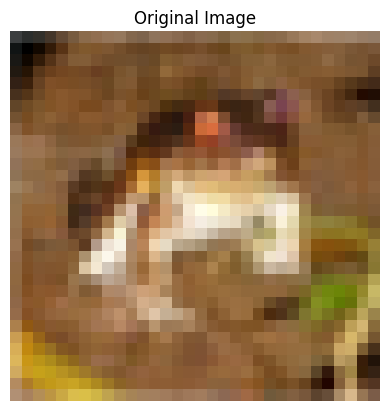

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9903764607537062..2.9159494283429406].


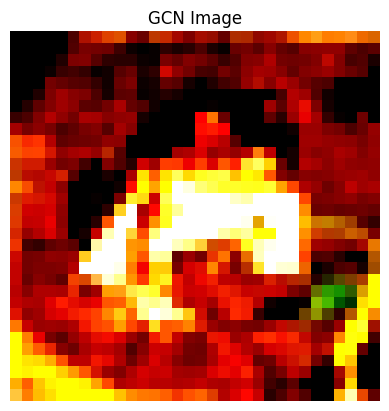

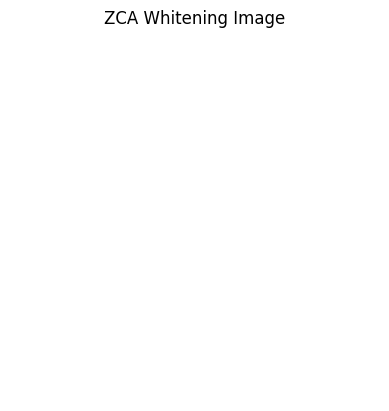

In [1]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# デバイスを指定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# ZCA白色化の実装
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device=device):  # 計算が重いのでGPUを用いる
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        """
        Argument
        --------
        images : numpy.ndarray
            入力画像（訓練データ全体）．(N, C, H, W)
        """
        x = torch.tensor(images[0]).reshape(1, -1).to(self.device)  # 画像（1枚）を1次元化
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)  # 平均値を格納するテンソル．xと同じ形状
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = torch.tensor(images[i]).reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        con_matrix -= torch.mm(self.mean.t(), self.mean)
        # E: 固有値 V: 固有ベクトルを並べたもの
        E, V = torch.linalg.eigh(con_matrix)  # 固有値分解
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze()+self.epsilon)**(-0.5))), V.t())  # A(\Lambda + \epsilon I)^{1/2}A^T
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean  # x - \bar{x}
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x

# データセットから画像を取得する関数
def load_image_from_project(config):
    project_name = config["Project_name"]
    dataset_dir = os.path.abspath(os.path.join(os.getcwd(), "../dataset", project_name))
    x_train = np.load(os.path.join(dataset_dir, "x_train.npy"))
    # ここでは1枚の画像を取得する
    return x_train[0]

# データセットをロードする関数
def load_dataset_from_project(config):
    project_name = config["Project_name"]
    dataset_dir = os.path.abspath(os.path.join(os.getcwd(), "../dataset", project_name))
    x_train = np.load(os.path.join(dataset_dir, "x_train.npy"))
    y_train = np.load(os.path.join(dataset_dir, "y_train.npy"))
    x_test = np.load(os.path.join(dataset_dir, "x_test.npy"))
    y_test = np.load(os.path.join(dataset_dir, "y_test.npy"))
    return x_train, y_train, x_test, y_test

# 画像を表示する関数
def show_image(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# GCNの実装（関数として定義）
def global_contrast_normalization(image, scale=1., epsilon=1e-8):
    """
    グローバルコントラスト正規化 (GCN) の実装
    """
    mean = np.mean(image)
    std = np.sqrt(np.var(image) + epsilon)
    return scale * (image - mean) / std

# メイン処理
if __name__ == "__main__":
    config = {
        "Project_name": "CIFAR-10"
    }

    # データセットをロード
    x_train, y_train, x_test, y_test = load_dataset_from_project(config)

    # データセットから1枚の画像を取得
    sample_image = x_train[0]

    # 画像が3次元配列であることを確認
    if len(sample_image.shape) == 3:  # (H, W, C) の場合
        sample_image = sample_image.reshape(1, *sample_image.shape)  # (1, H, W, C) に変換

    # ZCAホワイトニングを適用するために準備
    zca = ZCAWhitening(device=device)
    zca.fit(x_train)

    # 画像をテンソルに変換
    sample_image_tensor = torch.tensor(sample_image).permute(0, 3, 1, 2).float()  # (1, C, H, W)

    # GCNを適用
    gcn_image = global_contrast_normalization(sample_image.copy())
    gcn_image = gcn_image.reshape(32, 32, 3)  # 画像の形状に戻す

    # ZCAホワイトニングを適用
    zca_image = zca(sample_image_tensor).permute(0, 2, 3, 1).numpy()  # (1, H, W, C)
    zca_image = zca_image.reshape(32, 32, 3)  # 画像の形状に戻す

    # 元の画像を表示
    original_image = sample_image.reshape(32, 32, 3)
    show_image(original_image, "Original Image")

    # GCN画像を表示
    show_image(gcn_image, "GCN Image")

    # ZCAホワイトニング画像を表示
    show_image(zca_image, "ZCA Whitening Image")


cpu


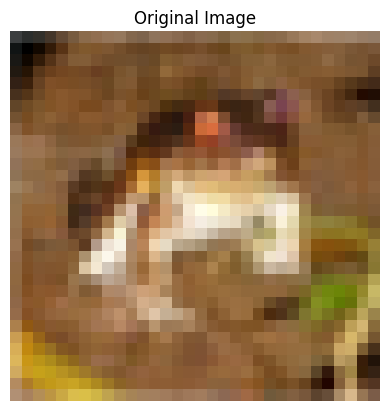

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9900525..2.9154747].


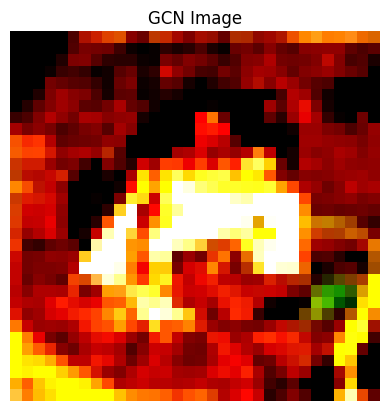

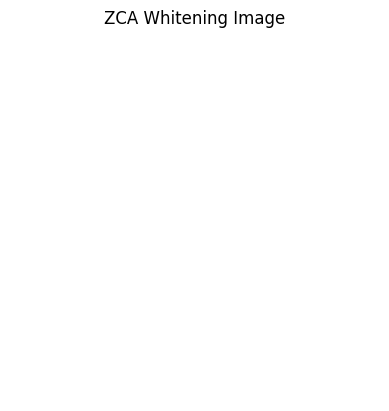

In [2]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# デバイスを指定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# データセットから画像を取得する関数
def load_image_from_project(config):
    project_name = config["Project_name"]
    dataset_dir = os.path.abspath(os.path.join(os.getcwd(), "../dataset", project_name))
    x_train = np.load(os.path.join(dataset_dir, "x_train.npy"))
    # ここでは1枚の画像を取得する
    return x_train[0]

# データセットをロードする関数
def load_dataset_from_project(config):
    project_name = config["Project_name"]
    dataset_dir = os.path.abspath(os.path.join(os.getcwd(), "../dataset", project_name))
    x_train = np.load(os.path.join(dataset_dir, "x_train.npy"))
    y_train = np.load(os.path.join(dataset_dir, "y_train.npy"))
    x_test = np.load(os.path.join(dataset_dir, "x_test.npy"))
    y_test = np.load(os.path.join(dataset_dir, "y_test.npy"))
    return x_train, y_train, x_test, y_test

# 画像を表示する関数
def show_image(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# GCNクラスの定義
class GCN():
    def __init__(self):
        pass

    def __call__(self, x):
        x = x.float()  # ここで浮動小数点型に変換
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean) / (std + 10**(-6))  # 0除算を防ぐ

# ZCA白色化クラスの定義
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):
        x = torch.tensor(images[0].reshape(1, -1)).to(self.device).float()  # 浮動小数点型に変換
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):
            x = torch.tensor(images[i].reshape(1, -1)).to(self.device).float()  # 浮動小数点型に変換
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
        con_matrix -= torch.mm(self.mean.t(), self.mean)
        E, V = torch.linalg.eigh(con_matrix)
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze() + self.epsilon)**(-0.5))), V.t())

    def __call__(self, x):
        size = x.shape
        x = torch.tensor(x.reshape(1, -1)).to(self.device).float()  # 浮動小数点型に変換
        x -= self.mean
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.cpu().numpy().reshape(size)
        return x

# メイン処理
if __name__ == "__main__":
    config = {
        "Project_name": "CIFAR-10"
    }

    # データセットをロード
    x_train, y_train, x_test, y_test = load_dataset_from_project(config)

    # データセットから1枚の画像を取得
    sample_image = x_train[0]

    # ZCAホワイトニングを適用するために準備
    zca = ZCAWhitening(device=device)
    zca.fit(x_train)

    # GCNを適用
    gcn = GCN()
    gcn_image = gcn(torch.tensor(sample_image).float())  # 浮動小数点型に変換

    # ZCAホワイトニングを適用
    zca_image = zca(sample_image)

    # 元の画像を表示
    original_image = sample_image.reshape(32, 32, 3)
    show_image(original_image, "Original Image")

    # GCN画像を表示
    gcn_image_show = gcn_image.cpu().numpy().reshape(32, 32, 3)
    show_image(gcn_image_show, "GCN Image")

    # ZCAホワイトニング画像を表示
    zca_image_show = zca_image.reshape(32, 32, 3)
    show_image(zca_image_show, "ZCA Whitening Image")
